<a href="https://colab.research.google.com/github/AnshUpadhyay639/Backprop-Implementation/blob/main/Language_Model_with_Custom_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# utility function we will use later when comparing our manualy calculated gradients to PyTorch gradients.
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item() # Exactly Similar.
  app = torch.allclose(dt, t.grad) # Approx Similiar.
  maxdiff = (dt - t.grad).abs().max().item() # Value with the Highest difference.
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g) # Vocab_size = No. of Characters = 27 with each char represented in 10 features.
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

vocab_size

4137


27

In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # fetch random 32 indexes.
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y (First Batch).
Xb, Yb

(tensor([[ 1,  1,  4],
         [18, 14,  1],
         [11,  5,  9],
         [ 0,  0,  1],
         [12, 15, 14],
         [ 0, 17,  1],
         [ 0,  0, 13],
         [13, 13,  1],
         [ 8, 25, 12],
         [ 0,  0, 26],
         [22, 15, 14],
         [19, 13,  9],
         [ 0,  0,  0],
         [ 0,  4,  5],
         [ 5, 14,  9],
         [18,  5,  5],
         [ 0,  4,  1],
         [ 1, 18,  1],
         [ 0,  0,  0],
         [ 0,  5, 12],
         [ 0, 10,  1],
         [ 9, 14,  1],
         [ 0,  0,  0],
         [ 0,  0, 18],
         [20,  5,  1],
         [ 0, 11, 15],
         [ 0,  0,  7],
         [ 0, 18,  5],
         [26,  5, 18],
         [ 0,  0, 14],
         [ 3,  5, 14],
         [ 0, 18, 15]]),
 tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
         26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18]))

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time
emb = C[Xb] # embed the characters into vectors [Feature Embedding: Further Represent those 3 features as 10].
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors OR nn.Flatten().[Normalize for Linear layer input = (32,3*10)].
# Linear layer 1:
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer (input logits = hprebn(n=32,features)):
bnmeani = 1/n*hprebn.sum(0, keepdim=True) # Summing all the rows i.e(sum of all the 32 samples) to make the shape (1,features) and then dividing it by n=32 gives the current batch mean.
bndiff = hprebn - bnmeani # Centering the data points around the Origin (0,0) instead of the mean. So now our Logits will be close to zero.[New mean = 0 but std() remains the same].
bndiff2 = bndiff**2 # Defines the Numerator in Variance Formula.
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) [Variance Calculation].
bnvar_inv = (bnvar + 1e-5)**-0.5 #[Inverse Variance : values with low variance (higher precision) are assigned higher weights, and values with high variance (lower precision) are assigned lower weights.][This ensures that data points with higher precision (smaller variance) contribute more to the result].
bnraw = bndiff * bnvar_inv # Dividing the centered data with the std (or mul with inv_std {same thing}) we make the new std = 1.[Now the Data points are evenly Scaled and Normalized].
hpreact = bngain * bnraw + bnbias #The bngain is the gamma parameter which scales the normalized data, and bnbias is the beta parameter which shifts it. This allows the network to learn the optimal mean and variance for the normalized inputs.
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values # Find the highest value amongst all the Logits.
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True) # Summation along the rows is being performed.
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...[Here we are normalizing the 'counts_sum'].
probs = counts * counts_sum_inv #[counts_sum_inv is a Column Tensor so Pytorch replicates this column 27 times to match the other matrix].
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean() # loss for 1 batch with "n" samples = -1/n*[logprobs(i,yi)].sum() ; dloss/dlogprobs = -1/n * 1[== one-hot(Yb) for all the 32 samples].

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik(as far as ik) there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad() # So that we can crossverify with PyTorch's Answers.
loss.backward()
loss

tensor(3.3354, grad_fn=<NegBackward0>)

In [ ]:
emb.shape

torch.Size([32, 3, 10])

In [ ]:
# Exercise 1: backprop through the whole thing manually.
# backpropagating through exactly all of the variables .
# as they are defined in the forward pass above, one by one.
# Note: The Gradients || Derrivatives has always the same shape as the OG matrixes.[Common Sense].
# Start with the Node before root = loss.grad = 1 [Final Function in DAG].
dlogprobs = torch.zeros_like(logprobs) # For Batchsize = n [dlogprobs.shape = (32,27)][We making this matrix as we have to store grads of samples other than those 32 whose grads are 0 for this batch as they dont contribute to the Loss()].
dlogprobs[range(n), Yb] = -1.0/n # Now store the gradient for all predicted samples on indexes (given by Yb) in a single batch.[Here out.grad = 1].
dprobs = (1.0 / probs) * dlogprobs # [local derrivative/gradient * global gradient(out.grad)][Here we are Boosting the grads of labels with low probs].
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # Here in the probs eqn ,2 operations are performed: Multiplication[Local grad * out.grad] && Replication[ As a single Column Vector will be converted to a row vector during BroadCasting and is then duplicated (used multiple times) to adjust with the shape of the other matrix; We sum the gradients when they are being reused; So as each row is being reused so we are using ".sum(dim=1)"" (sums up all the columns) to sum up their grads too].
dcounts = counts_sum_inv * dprobs # [Local grad * out.grad][No summation required as there will be BroadCasting w.r.t "counts"][Summation will be in counts_sum_inv matrix and not in Counts].
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv #[Local.grad * out.grad].
dcounts += torch.ones_like(counts) * dcounts_sum # [[Local.grad * out.grad] where Local.grad is calculated by converting (32,1) matrix to a (32,27); NOW imagine a column tensor 1st element b1(from 32,1 matrix) which is formed after adding a1 + a2 + a3 ; and we already know b1.grad So db1/da1 = 1 same goes for a2 and a3 ; so grads of a1 , a2, a3 == 1 for a single row ; similarly for all the rows the respective grads will be 1]["+=" used as "counts" is used more than once].
dnorm_logits = counts * dcounts #[Local.grad * out.grad where Local.grad = normlogits.exp() == counts only (see above)].
dlogits = dnorm_logits.clone() # During '+' or '-' operation the grads are directly transfered but logits have a "+" sign so copied grads will be positive][.clone() is an Alt].
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # [Logit_maxes has "-" sign so -ve logits will be transfered][Replication: Summation of all the Columns will be performed].
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # [Alternative of what we did to calculate 'dlogprobs'][out.grad = dlogitmaxes].
dh = dlogits @ W2.T # [Hint: You can see this if u look at the shapes of root eqn = logits][Derrivation in my Notebook].
dW2 = h.T @ dlogits # Same as Above.
db2 = dlogits.sum(0) #[Due to "+" operation dlogits.grad flows into this][Replication : .sum(0) up all the rows][Derrivation in Notebook].
dhpreact = (1.0 - h**2) * dh #[Local.grad * out.grad].
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact # We didnt sum here as bnraw matrix has already a same shape as hpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv #[Local.grad * out.grad].
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar #[Local.grad * out.grad].[Matrix of all 1s because due to summation grads are all 1s. Shape is same as bndiff2].
dbndiff += (2*bndiff) * dbndiff2 #[Local.grad * out.grad].
dhprebn = dbndiff.clone() # Gradient flows/copies due to "+" sign.
dbnmeani = (-dbndiff).sum(0) # Gradient flows/copies due to "-" sign.[Replication: .sum(0)].[This gradient will return False during comparison below as it is not completely made up of leaf nodes; Its 1 Node dependencies goes further].
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani) # [Converse Rule: BroadCasting happens in backward pass as .sum() is used in the Forward Pass].
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape) # Re-represent the Original View of what shape it was before i.e [Make demb.shape = emb.shape but also include out.shape].
dC = torch.zeros_like(C) # First replicate an empty C.
for k in range(Xb.shape[0]): # Not iterate over Xb rows and cols and fill dC.
  for j in range(Xb.shape[1]):
    ix = Xb[k,j] # Pluck out each value.
    dC[ix] += demb[k,j] # Place it in right position of dC using out.matrix[Use "+=" as there can be multiple 'ix' with same value so add their grads].

# Verifying our grads with PyTorch.grads:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:

  # logit_maxes = logits.max(1, keepdim=True).values
  # norm_logits = logits - logit_maxes # subtract max for numerical stability
  # counts = norm_logits.exp()
  # counts_sum = counts.sum(1, keepdims=True)
  # counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
  # probs = counts * counts_sum_inv
  # logprobs = probs.log()
  # loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb) # Now we can calculate 'dlogits' directly. [Function of Cross_Entropy() uses SoftMAX for a single sample it does: 1. Perform .exp() ||||2. Divid by .sum() of all exps to make them in range (0,1) Softmax part done |||| 3. Perform -log (O/p of Softmax)].
print(loss_fast.item(), 'diff:', (loss_fast - loss).item()) # Now we have to find "dL/dlogiti" for back prop grads.

3.335381031036377 diff: 2.384185791015625e-07


In [ ]:
# backward pass
# See in Notebook where the below came from:
dlogits = F.softmax(logits, 1) # Here dim = 1 means we want to do the softmax for a single data point(summing all the single row elements || Summation ALONG the rows) that is adding the columns (divide each exp() of a row divide by sum of columns.exp()).
dlogits[range(n), Yb] -= 1 # If Logiti == Yb we substract that by 1.(To make them move more towards -ve gradient direction)[Look derrivation in Notebook][This is dlogits for a single sample].
dlogits /= n # To get the Average dlogits of a batch you divide by batchsize.

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 7e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


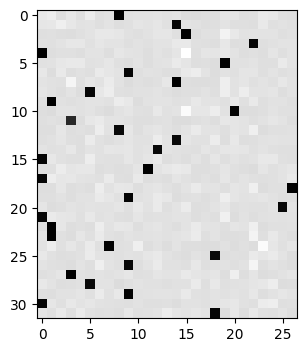

In [ ]:
# Visualizing "dlogits" of Shape(32,27):
plt.figure(figsize=(4, 4)) # Black spots are the position of corrected idx where we substracted 1 so that they move more closely towards -ve grad direction.
plt.imshow(dlogits.detach(), cmap='gray') # These Black sq are pulled up by a force of dlogits[blacki] which is basically the grad and vice versa white is pulled down.

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go.
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
  # bnmeani = 1/n*hprebn.sum(0, keepdim=True)
  # bndiff = hprebn - bnmeani
  # bndiff2 = bndiff**2
  # bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
  # bnvar_inv = (bnvar + 1e-5)**-0.5
  # bnraw = bndiff * bnvar_inv
  # hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)) # Backprop expression fora single batch of 32 for BatchNorm1D [Refer to Notebook for derrivation of a single sample].

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
